# One row per patient model

To keep it simple, to start off with we simply model the patients as a single row, i.e. each feature is a scalar or a categorical variable.

See `03_mortality_red_dataset` notebook for more info.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import clear_output

establish connection to DB and define helper function for running queries

In [2]:
from proto.etl.config import SSHInfoEicu, DBInfoEicu
from proto.etl.utils import connect_to_db_via_ssh, run_eicu_query, get_column_completeness, load_schema_for_modelling
conn = connect_to_db_via_ssh(SSHInfoEicu, DBInfoEicu)
cursor = conn.cursor()
query_schema = 'set search_path to eicu_crd;'

#### Load data, get target variable

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc

import tensorflow as tf
import keras_metrics as km
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, BatchNormalization, SpatialDropout1D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
# load vars
df = pd.read_csv('orpp_all.csv').set_index('patientunitstayid')

# load targets
query = """
select p.patientunitstayid, i.hosp_mort, icu_los_hours
from patient_top5hospitals_mort_dataset p
inner join icustay_detail i
on p.patientunitstayid=i.patientunitstayid
"""
df_y = run_eicu_query(query, conn).set_index('patientunitstayid')

# there are 100 missing mortality labels, we impute them with zero
#re-order y vars to match the order of X
df_y.fillna(0, inplace=True)
df_y = df_y.loc[df.index]
df_y.to_csv('mort_y.csv')

#### Setup encoders for the categorical input vars

In [5]:
cat_encoders = {
    'ethnicity': LabelEncoder(),
    'hospital_region': LabelEncoder(),
    'unittype': LabelEncoder(),
    'apachedxgroup': LabelEncoder()
}
for col, label_encoder in cat_encoders.items():
    df[col] = label_encoder.fit_transform(df[col])

#### Scale numeric input features

In [6]:
cat_vars = [
    'ethnicity',
    'hospital_region',
    'unittype',
    'apachedxgroup'
]
num_cols = list(df.columns[4:].values)

# originally I didn't scale the embed dimensions, but this turned out to be terrible and made 
# the training of the network impossible, so we train all numerical features equally
scaler = RobustScaler(quantile_range=(10.0, 90.0))
df[num_cols] = scaler.fit_transform(df[num_cols].values)

#### Setup training/test data

In [127]:
# do train-test split without scikit to keep the data with its col names - see later
np.random.seed(12)
test_ratio = 0.1
train_ix = np.random.rand(len(df)) < 1 - test_ratio

# define X and y, then split it into train (90%) and test (10%)
X = df.values
y = df_y['hosp_mort'].values
df_X_train = df[train_ix]
y_train = y[train_ix]
df_X_test = df[~train_ix]
y_test = y[~train_ix]

In [128]:
def get_data_dict(df, num_cols):
    return {
        'ethnicity': np.array(df.ethnicity),
        'hospital_region': np.array(df.hospital_region),
        'unittype': np.array(df.unittype),
        'apachedxgroup': np.array(df.apachedxgroup),
        'num_cols': df[num_cols].values
    }
X_train = get_data_dict(df_X_train, num_cols)
X_test = get_data_dict(df_X_test, num_cols)  

#### Define basic FFN model and its hyperparams

In [129]:
DENSE_SIZE = 2014
BATCH_SIZE = 256
EPOCHS = 20
DROPOUT = 0.5
STEPS = int(len(X_train) / BATCH_SIZE) * EPOCHS

# set up decaying learning rate for Adam
LR_INIT, LR_FIN = 0.001, 0.0001
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
lr_decay = exp_decay(LR_INIT, LR_FIN, STEPS)
optimizer_adam = Adam(lr=0.001, decay=lr_decay, amsgrad=True)

In [130]:
# cat features embedded
in_et = Input(shape=(1,), name='ethnicity')
emb_et = Embedding(cat_encoders['ethnicity'].classes_.shape[0], 2)(in_et)
in_hr = Input(shape=(1,), name='hospital_region')
emb_hr = Embedding(cat_encoders['hospital_region'].classes_.shape[0], 2)(in_hr)
in_ut = Input(shape=(1,), name='unittype')
emb_ut = Embedding(cat_encoders['unittype'].classes_.shape[0], 2)(in_ut)
in_ag = Input(shape=(1,), name='apachedxgroup')
emb_ag = Embedding(cat_encoders['apachedxgroup'].classes_.shape[0], 5)(in_ag)

cat_feats = concatenate([emb_et, emb_hr, emb_ut, emb_ag])
cat_feats = Flatten()(cat_feats)

# num features with 2 layers and dropout
in_num = Input(shape=(len(num_cols),), name='num_cols')
num_feats = Dense(DENSE_SIZE, activation='relu')(in_num)
num_feats = Dropout(DROPOUT)(num_feats)
num_feats = Dense(DENSE_SIZE/2, activation='relu')(num_feats)
num_feats = Dropout(DROPOUT)(num_feats)

# concat cat and num features add final dense layer, output layer and compile model
all_feats = concatenate([cat_feats, num_feats])
all_feats = Dense(DENSE_SIZE/4, activation='relu')(all_feats)
all_feats = Dropout(DROPOUT)(all_feats)

out = Dense(1, activation='sigmoid')(all_feats)
model = Model(inputs=[in_et, in_hr, in_ut, in_ag, in_num], outputs=[out])
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer_adam, 
    metrics=[km.binary_precision(), km.binary_recall()]
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num_cols (InputLayer)           (None, 207)          0                                            
__________________________________________________________________________________________________
ethnicity (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
hospital_region (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
unittype (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
apachedxgr

#### Setup callbacks to monitor training

In [131]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision',
    min_delta=0,
    patience=20,
    verbose=0, 
    mode='auto'
)

class PlotLosses(tf.keras.callbacks.Callback):
    plt.rcParams["figure.figsize"] = (20,10)
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.prec = []
        self.val_prec = []
        self.rec = []
        self.val_rec = []
        
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.prec.append(logs.get('precision'))
        self.val_prec.append(logs.get('val_precision'))
        self.rec.append(logs.get('recall'))
        self.val_rec.append(logs.get('val_recall'))
        self.i += 1
        
        clear_output(wait=True)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend(loc="upper right")
        ax1.title.set_text('Loss')
        
        ax2.plot(self.x, self.prec, label="precision")
        ax2.plot(self.x, self.val_prec, label="val_precision")
        ax2.legend(loc="upper right")
        ax2.title.set_text('Precision')
        
        ax3.plot(self.x, self.rec, label="recall")
        ax3.plot(self.x, self.val_rec, label="val_recall")
        ax3.legend(loc="upper right")
        ax3.title.set_text('Recall')
        
        plt.show()
        
plot_losses = PlotLosses()

#### Train model

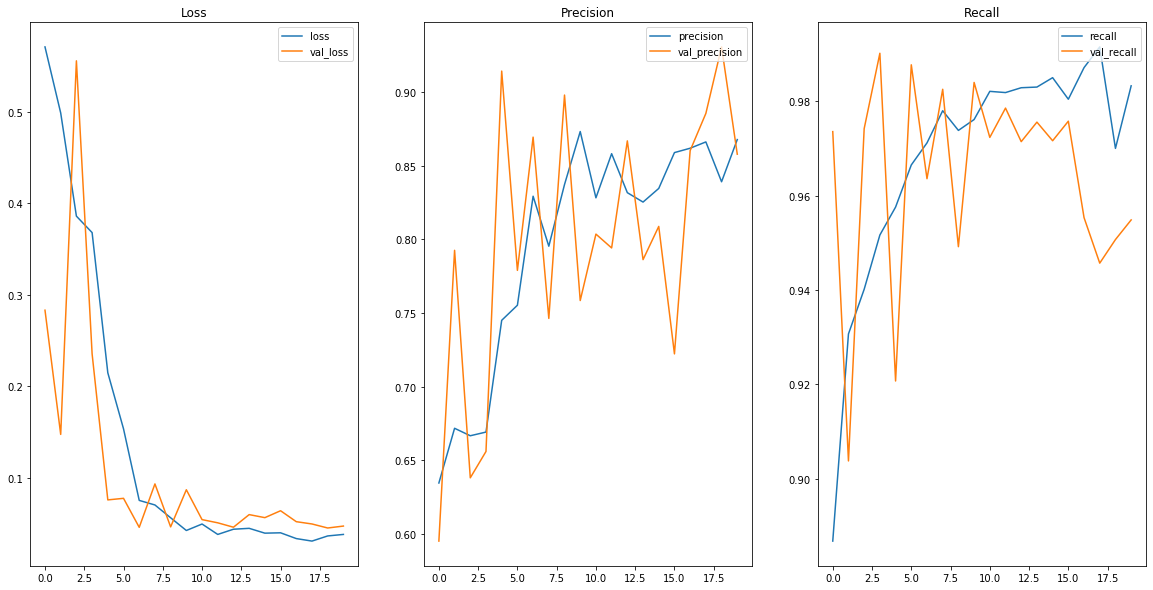

14915/14915 [==============================] - 1s 81us/sample - loss: 0.0379 - precision: 0.8679 - recall: 0.9832 - val_loss: 0.0471 - val_precision: 0.8579 - val_recall: 0.9548


In [132]:
with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    model.fit(
        X_train, y_train, 
        validation_data=(X_test, y_test),
        class_weight={0: 1, 1: 10},
        callbacks=[plot_losses],
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        shuffle=True, 
        verbose=1
    )
    model.save("model_mort.h5")

#### Plot PR curve on test set

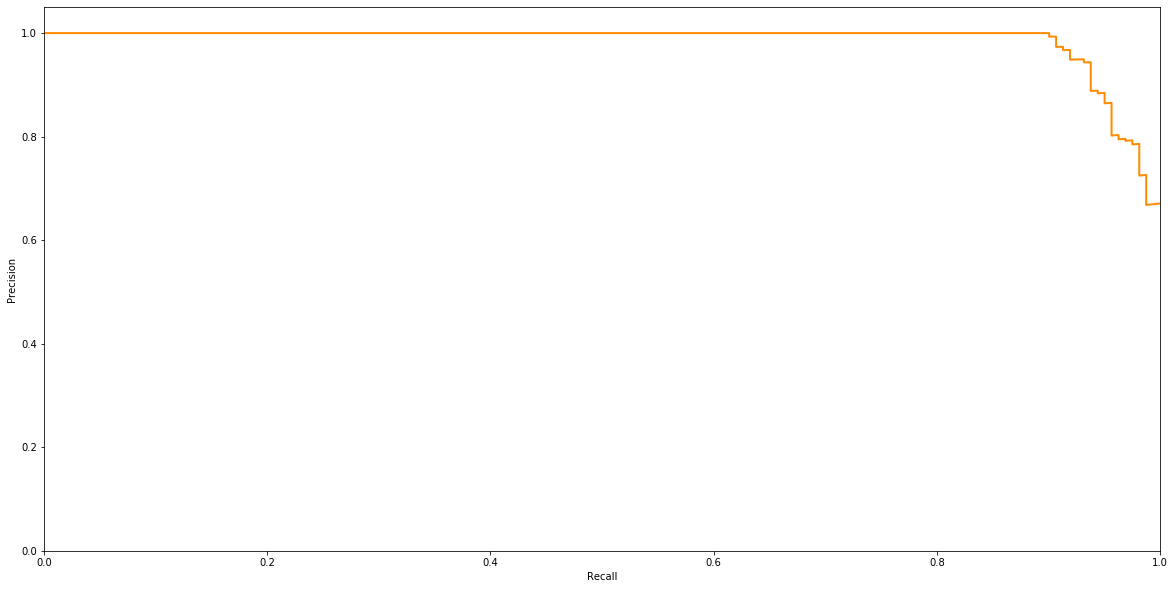

In [133]:
# load model
custom_objects = {
    'binary_precision': km.binary_precision(),
    'binary_recall': km.binary_recall(),
}
model = load_model('model_mort.h5', custom_objects=custom_objects)

# predict test and calculate PR
preds = model.predict(X_test)
prec, rec, _ = precision_recall_curve(y_test, preds.ravel())

# plot PR
plt.figure()
lw = 2
plt.plot(rec, prec, color='darkorange', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### Expereimental results re feature importance

Changing what features the model sees. Note, this is on the train set.

| Variables used | Precision | Recall |
|---|---|---|
| only diag embedding features | 0.36  |  0.83 |
| only lab values   | 0.63   | 0.96  |
| only lab + diag  | 0.72  | 0.97  |
| only apache aps vars | 0.52 | 0.95 |
| only apache pred vars | 0.91 | 0.99 |
| all apache together | 0.92 | 0.995 |
| everything excluding diag | 0.97.5 | 1 |



#### Compare the Apache prediction of mortality to our model

In [122]:
query = """
select a.patientunitstayid, a.predictedicumortality
from (
      apachepatientresult as a
         join (select patientunitstayid from patient_top5hospitals_mort_dataset) as p
              on p.patientunitstayid = a.patientunitstayid
    )

"""
df_apache_results = run_eicu_query(query, conn)

In [134]:
# some patients have multiple scores from different apache versions, so we average them.
df_apache_results.predictedicumortality = df_apache_results.predictedicumortality.astype(np.float)
df_apache_results = df_apache_results.groupby('patientunitstayid').mean()

In [135]:
# create a DF from the true, model_pred and apache_pred vectors
df_pred = pd.DataFrame(list(zip(y_test, preds.ravel())), columns=['y_true', 'y_pred'], index=df_X_test.index)
df_pred = df_pred.join(df_apache_results, how='inner')

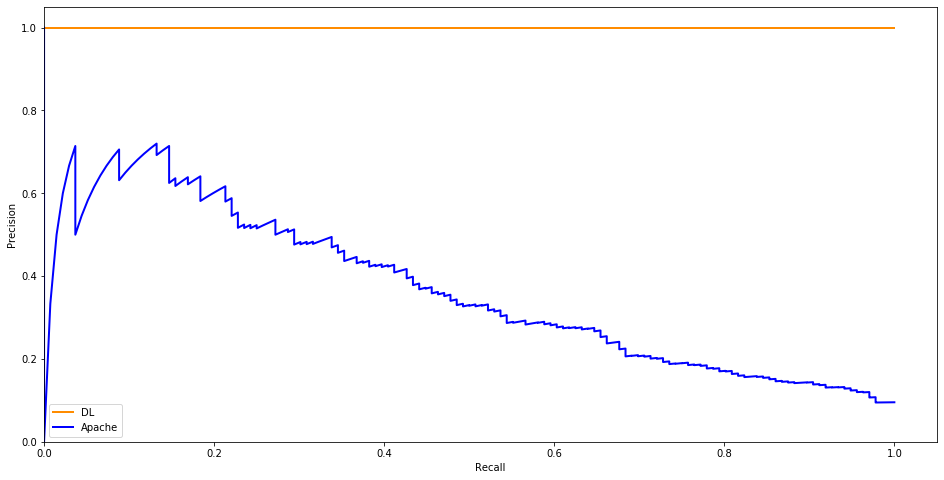

In [136]:
# plot the two PRs

# predict test and calculate PR
prec_m, rec_m, _ = precision_recall_curve(df_pred.y_true, df_pred.y_pred)
prec_a, rec_a, _ = precision_recall_curve(df_pred.y_true, df_pred.predictedicumortality)

# plot PR
plt.rcParams["figure.figsize"] = (16,8)
plt.figure()
lw = 2
plt.plot(rec_m, prec_m, color='darkorange', lw=lw, label='DL ')
plt.plot(rec_a, prec_a, color='blue', lw=lw, label='Apache')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()